### HMF algorithm ###

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**12/27**
1) run 1500, 6000 spectra, see how it scales

2) run it with many more iterations (10, 20) to see it converge

    - make a set of eigenvectors with as many spectra as possible
    
3) pass HMF vectors (model M=V@C) back into empca without noise-weighting

4) confirm that this updated notebook is in github


In [2]:
# PSEUDOCODE
# transpose S so fluxes = fluxes.T
# an input to hmf_weighted should be how many vectors to solve for, j
# V has dim (nwave, n)
def hmf_weighted(fluxes, ivars, j, num_iter=20):
    """
    # TODO: docstring
    """
    # ensures that the number of nonzero observations must be 5x 
    # the number of vectors, j=nvec
    fluxes, ivars = enough_obs(fluxes, ivars, j, mult_factor=10)
    
    
    S = fluxes.T # with dimensions S[nwave, nspec]
    W = ivars.T # the weights matrix with dimensions W[nwave, nspec]
        
    i = 0
    V = np.random.rand(S.shape[0], j)
    C = np.zeros((j, S.shape[1]))
    
    # track chi stat over time
    chistats = np.zeros((num_iter,))
    
    while(i < num_iter): #TODO: Legit Stopping condition
        C = solveCoeffs(S, W, V, C)
        V = solveEigvecs(S, W, V, C)
        
        # evaluate model
        chi_stat = eval_model(S, W, V, C)
        print('chi stat is {}'.format(chi_stat), flush=True)
        chistats = np.append(chistats, chi_stat)

        i+=1
    C = solveCoeffs(S, W, V, C) # solve coeffs one last time
    return V, C, chistats

In [3]:
def solveCoeffs(S, W, V, C):
    """
    TODO: docstring
    """
    output_cached_mat = np.zeros((C.shape[0], V.shape[0]))
    output_A = np.zeros((C.shape[0], C.shape[0]))
    output_b = np.zeros((C.shape[0],))
    
    for i in range(C.shape[1]): # iterate over all rows of S
        spec_i = S[:, i]
        D = np.diag(W[:, i]) # diagonal matrix of weights corresponding to spec_i
        
        # V^T * D * spec_i = (V^T * D * V) * coeff[:, i]
        # solver determines x where Ax = b, solve for the coefficients column that corresponds to spec_i
        np.dot(V.T, D, out=output_cached_mat)
        np.dot(output_cached_mat, V, out=output_A)
        np.dot(output_cached_mat, spec_i, out=output_b)
        
        coeffs_i = np.linalg.solve(output_A, output_b)
        C[:, i] = coeffs_i
    return C

In [4]:
def solveEigvecs(S, W, V, C):
    """
    TODO: docstring
    """
    output_cached_mat = np.zeros((V.shape[1], C.shape[1]))
    output_A = np.zeros((V.shape[1], V.shape[1]))
    output_b = np.zeros((V.shape[1],))
    
    for lam in range(V.shape[0]): # iterate over all wavelengths
        wave_lam = S[lam, :]
        D = np.diag(W[lam, :])
        
        # C * D * wave_lam = (C * D * C.T) * eigvec[:, j]
        # solver determines x where Ax = b
        np.dot(C, D, out=output_cached_mat)
        np.dot(output_cached_mat, C.T, out=output_A)
        np.dot(output_cached_mat, wave_lam.T, out=output_b)
        
        eigvec_lam = np.linalg.solve(output_A, output_b)
        
        V[lam] = eigvec_lam # V[lam] = V[lam, :]
    return V

In [5]:
def enough_obs(fluxes, ivars, j, mult_factor=5):
    """
    TODO: docstring
    """
    num_ivars_for_wavelength = np.sum(ivars>0, axis=0)
    nonzero_idx = num_ivars_for_wavelength > mult_factor*j
    fluxes = fluxes[:, nonzero_idx]
    ivars = ivars[:, nonzero_idx]
    return fluxes, ivars

In [6]:
def eval_model(S, W, V, C):
    """
    Evaluates the model by computing Delta = S - VC 
    and then calculating Chi2 = SUM[W(lam, i) * Delta(lam, i)**2] over all wavelengths lam and spectra i
    """
    Delta = S - np.dot(V, C)
    D_squared = np.multiply(Delta, Delta)
    chi_stat = np.multiply(W, D_squared)
    return np.sum(np.sum(chi_stat))

### running HMF

In [7]:
###Extract from file
import pickle
with open("../qso/fluxes_5000_good.pkl","rb") as file:
    fluxes = pickle.load(file)

with open("../qso/ivars_5000_good.pkl","rb") as file:
    ivars = pickle.load(file)

In [ ]:
V, C = hmf_weighted(fluxes, ivars, 5)

In [ ]:
V.shape

In [ ]:
C.shape

In [ ]:
final_chi = eval_model(fluxes.T, ivars.T, V, C)
print(final_chi)

In [ ]:
plot(chistats);

In [ ]:
with open("model_5000_V.pkl","wb") as file:
    pickle.dump(V,file)
    
with open("model_5000_C.pkl", "wb") as file:
    pickle.dump(C, file)

In [ ]:
###Extract from file
import pickle
with open("model_5000_V.pkl","rb") as file:
    V = pickle.load(file)

with open("model_5000_C.pkl","rb") as file:
    C = pickle.load(file)

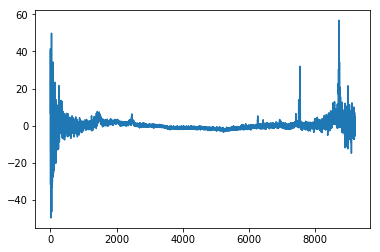

In [40]:
plot(V[:,0]);

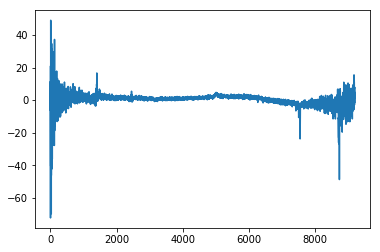

In [41]:
plot(V[:,1]);

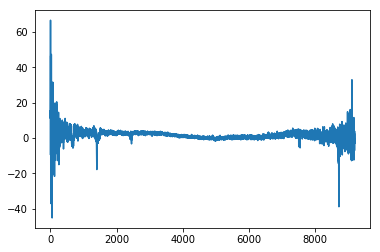

In [42]:
plot(V[:,2]);

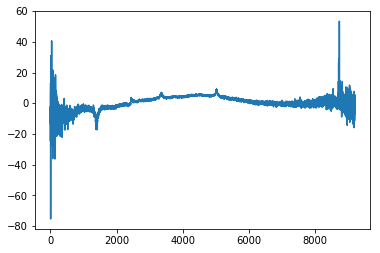

In [43]:
plot(V[:,3]);

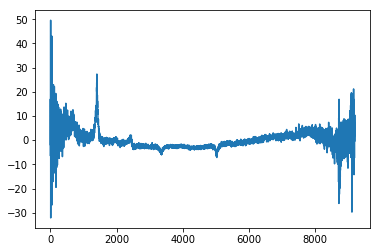

In [44]:
plot(V[:,4]);